In [43]:
import pandas as pd
import nltk
import gzip
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import hashlib
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, precision_score, average_precision_score, fbeta_score, recall_score

In [2]:
review_text = 'reviewText'
all_keys = ['reviewText', 'reviewerID', 'reviewTime', 'asin', 'reviewerName', 'overall', 'unixReviewTime', 'summary', 'helpful']
req_keys = ['asin', 'reviewText', 'overall']

In [75]:
wordlist = {}
wordindex = {}
freq_all = []
freq = [[] for i in range(5)]
i_star = [0, 0, 0, 0, 0]

phraselist = {}
phraseindex = {}
freq_all_p = []
freq_p = [[] for i in range(5)]

sentiment_pos = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
adj = ['JJ', 'JJR', 'JJS']
verb = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
negation_words = ['not', 'Not']
threshold = 10
index_above_threshold = {}
sentiment_score = []
index_above_threshold_p = {}
sentiment_score_p = []

In [192]:
def preInitialize():
    global wordlist, wordindex, phraselist, phraseindex
    
    wordlist = {}
    wordindex = {}
    phraselist = {}
    phraseindex = {}

def initialize():
    global freq_all, freq, i_star, sentiment_score, threshold, index_above_threshold 
    global freq_all_p, freq_p, index_above_threshold_p, sentiment_score_p

    l_w = len(wordlist)
    freq_all = [0]*l_w
    freq = [[0]*l_w for i in range(5)]

    l_p = len(phraselist)
    freq_all_p = [0]*l_p
    freq_p = [[0]*l_p for i in range(5)]

    i_star = [0, 0, 0, 0, 0]

    sentiment_score = []
    sentiment_score_p = []
    threshold = 10
    index_above_threshold = {}
    index_above_threshold_p = {}

In [195]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g:
        yield eval(l) 

def count_tokens(tokens, overall):
    i_star[overall-1]+=1

    for token, pos in tokens:
        try:
            index = wordlist[token]
            freq_all[index] += 1
            freq[overall-1][index] += 1
        except:
            pass

def count_phrase(phrases, overall):
    for token, pos in phrases:
        index = phraselist[token]
        freq_all_p[index] += 1
        freq_p[overall-1][index] += 1

def phrase_tagger(tokens):
    neg_phrase = []
    j = 0
    i = 0
    l = len(tokens)
    while i < (l - 2):
        if tokens[i][0] in negation_words:
            if tokens[i + 1][1] in adj:
                neg_phrase.append((tokens[i][0] + ' ' + tokens[i + 1][0], 'NOA'))
                i+=1
            elif tokens[i+1][1] in verb:
                neg_phrase.append((tokens[i][0] + ' ' + tokens[i + 1][0], 'NOV'))
                i+=1
            elif tokens[i+2][1] in adj:
                neg_phrase.append((tokens[i][0] + ' ' + tokens[i + 1][0] + ' ' + tokens[i + 2][0], 'NOA'))
                i+=2
            elif tokens[i+2][1] in verb:
                neg_phrase.append((tokens[i][0] + ' ' + tokens[i + 1][0] + ' ' + tokens[i + 2][0], 'NOV'))
                i+=2
        i+=1
    return neg_phrase

def pos_tagger(sentence):
    return nltk.pos_tag(nltk.word_tokenize(sentence))

def initializeWordPhraselist(tokens, phrases, cntr1, cntr2):
    for token, pos in tokens:
        if pos in sentiment_pos:
            try:
                index = wordlist[token]
            except:
                wordlist[token] = cntr1
                wordindex[cntr1] = token
                cntr1+=1
                
    for token, pos in phrases:
        try:
            index = phraselist[token]
        except:
            phraselist[token] = cntr2
            phraseindex[cntr2] = token
            cntr2+=1
        
    return cntr1, cntr2

def getDF_all(path):
    i = 0
    df = {}
    cntr1 = 0
    cntr2 = 0
    for d in parse(path):
        df[i] = d
        df[i][review_text] = pos_tagger(df[i][review_text])
        df[i]['phraseTokens'] = phrase_tagger(df[i][review_text])
        cntr1, cntr2 = initializeWordPhraselist(df[i][review_text], df[i]['phraseTokens'], cntr1, cntr2)
        i+=1

    return pd.DataFrame.from_dict(df, orient='index')

def getDF(path):
    i = 0
    df = {}
    cntr1 = 0
    cntr2 = 0
    for d in parse(path):
        df[i] = {key: d[key] for key in req_keys}
        # print(cntr, df[i]['overall'])
        df[i][review_text] = pos_tagger(df[i][review_text])
        df[i]['phraseTokens'] = phrase_tagger(df[i][review_text])
        cntr1, cntr2 = initializeWordPhraselist(df[i][review_text], df[i]['phraseTokens'], cntr1, cntr2)
        i += 1

    return pd.DataFrame.from_dict(df, orient='index')

In [197]:
SOURCES = ['data/reviews_Musical_Instruments_5.json.gz']

preInitialize()
df = pd.DataFrame()
#df = pd.DataFrame({'reviewText': [], 'reviewerID': [], 'reviewTime': [], 'asin': [], 'reviewerName': [], 'overall': [], 'unixReviewTime': [], 'summary': [], 'helpful': []})
for path in SOURCES:
    df = df.append(getDF(path))

print(len(wordlist))
print(len(phraselist))

initialize()
for index, review in df.iterrows():
    count_tokens(review[review_text], int(review['overall']))
    count_phrase(review['phraseTokens'], int(review['overall']))

16399
1666


In [198]:
len(phraselist)

1666

In [199]:
len(wordlist)

16399

In [200]:
np_freq_all = np.array(freq_all)

In [201]:
np_freq_all.shape

(16399,)

In [202]:
np_freqs = np.array([freq[0], freq[1], freq[2], freq[3], freq[4]])

In [203]:
np_freqs.shape

(5, 16399)

In [204]:
#nltk.help.upenn_tagset()

In [235]:
def plot_freq_start(i_star):
    plt.xticks(range(5), ['1-star', '2-star', '3-star', '4-star', '5-star'])
    plt.yticks()
    plt.bar(range(5), i_star, align='center', color='green')
    plt.show()

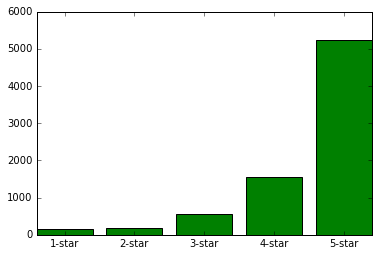

In [236]:
plot_freq_start(i_star)

In [206]:
def sentimentScore():
    cntr = 0
    for word, index in wordlist.items():
        if freq_all[index] > threshold:
            num = 0
            den = 0
            for i in range(5):
                temp = (i_star[4]/i_star[i]) * freq[i][index]
                num += (i+1) * temp
                den += temp
            #print(num/den)
            sentiment_score.append((num/den))
            index_above_threshold[index] = cntr
            cntr += 1

    cntr = 0
    for word, index in phraselist.items():
        if freq_all_p[index] > threshold:
            num = 0
            den = 0
            for i in range(5):
                temp = (i_star[4]/i_star[i]) * freq_p[i][index]
                num += (i+1) * temp
                den += temp
            #print(num/den)
            sentiment_score_p.append((num/den))
            index_above_threshold_p[index] = cntr
            cntr += 1

In [207]:
sentimentScore()

In [208]:
len_sen_tokens = len(sentiment_score)
len_sen_tokens

3230

In [209]:
len(sentiment_score_p)

57

In [219]:
def f_vector_s(sentence):
    pos_tokens = nltk.pos_tag(nltk.word_tokenize(sentence))
    phrase_tokens = phrase_tagger(pos_tokens)
    return f_vector_p(pos_tokens, phrase_tokens)

def f_vector_p(pos_tokens, phrase_tokens):
    f1 = [ 0 ]*len(sentiment_score)
    total_score = 0.0
    num_tokens = 0.0
    for token, pos in pos_tokens:
        if pos in sentiment_pos:
            try:
                index = wordlist[token]
                cntr = index_above_threshold[index]
                f1[cntr] = 1
                total_score += sentiment_score[cntr]
                num_tokens = num_tokens + 1.0
            except:
                pass

    if num_tokens == 0:
        avg_score = 0
    else:
        avg_score = total_score/num_tokens

    f1.append(avg_score)

    f2 = [ 0 ]*len(sentiment_score_p)
    total_score = 0.0
    num_tokens = 0.0
    for token, pos in phrase_tokens:
        try:
            index = phraselist[token]
            cntr = index_above_threshold_p[index]
            f2[cntr] = 1
            total_score += sentiment_score_p[cntr]
            num_tokens = num_tokens + 1.0
        except:
            pass

    if num_tokens == 0:
        avg_score = 0
    else:
        avg_score = total_score/num_tokens

    f1 = f1 + f2
    f1.append(avg_score)
    #return [hashlib.md5(''.join(f1).encode()).hexdigest(), avg_score]
    #return [hash(''.join(f1)), avg_score]
    return np.array(f1)

In [220]:
preInitialize()
data = pd.DataFrame()
for file in SOURCES:
    data = data.append(getDF_all(file))

In [221]:
len(data)

10261

In [229]:
class Vectorize():
    def fit(self, data):
        # print(len(data))
        initialize()
        # self.pos_s = []
        cntr = 0
        cntr2 = 0
        for index, review in data.iterrows():
            #print(review)
            count_tokens(review['reviewText'], int(review['overall']))
            count_phrase(review['phraseTokens'], int(review['overall']))
            # self.pos_s.append(pos)
        sentimentScore()

    def transform(self, data):
        feature_vector_list = []
        for index, review in data.iterrows():
            feature_vector_list.append(f_vector_p(review['reviewText'], review['phraseTokens']))
        return np.array(feature_vector_list)

    def fit_transform(self, data):
        # print(len(data))
        self.fit(data)
        return self.transform(data)

In [223]:
#phraselist

In [213]:
vectorize = Vectorize()
feature_vector = vectorize.fit_transform(df)

10261
10261


In [214]:
feature_vector.shape

(10261, 3289)

In [215]:
classifier = MultinomialNB()
targets = data['overall'].values
classifier.fit(feature_vector, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [216]:
targets

array([ 5.,  5.,  5., ...,  4.,  4.,  4.])

In [217]:
classifier.predict(f_vector_s('Not much to write about here, but it does exactly what it\'s supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,').reshape(1, -1))

array([ 5.])

In [237]:
def kFoldTest(classifier):
    pipeline = Pipeline([
            ('vectorizer', Vectorize()),
            ('classifier', MultinomialNB())
        ])

    kFold = KFold(n = len(data), n_folds = 4)
    scores = []
    confusionMatrix = np.array([[0]*5]*5)
    vectorizer = Vectorize()
    #classifier = MultinomialNB()
    #classifier = BernoulliNB()
    #classifier = SVC()
    #classifier = RandomForestClassifier()
    for train_indices, test_indices in kFold:
        train_data = data.iloc[train_indices]
        train_y = data.iloc[train_indices]['overall'].values

        test_data = data.iloc[test_indices]
        test_y = data.iloc[test_indices]['overall'].values

        fs = vectorizer.fit_transform(train_data)
        classifier.fit(fs, train_y)
        # print(fs.shape)
        fs = vectorizer.transform(test_data)
        # print(fs.shape)
        predictions = classifier.predict(fs)

        # print(test_y.shape)
        # print(predictions.shape)
        # print(confusion_matrix(test_y, predictions))
        confusionMatrix += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label = 5, average='weighted')
        scores.append(score)

    print('Total movies classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusionMatrix)

In [238]:
kFoldTest(RandomForestClassifier())

Total movies classified: 10261
Score: 0.585194914767
Confusion matrix:
[[  11    3   17   22  164]
 [   5    4   13   36  192]
 [   6    5   37  121  603]
 [  12    1   38  281 1752]
 [   7    6   57  473 6395]]


In [239]:
kFoldTest(MultinomialNB())

Total movies classified: 10261
Score: 0.607302008853
Confusion matrix:
[[  15    6   32   33  131]
 [   2    2   38   59  149]
 [   1    2   68  202  499]
 [   1    1   67  421 1594]
 [   5    3   95  562 6273]]


In [240]:
kFoldTest(SVC())

/opt/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Total movies classified: 10261
Score: 0.545560039584
Confusion matrix:
[[   0    0    0    0  217]
 [   0    0    0    0  250]
 [   0    0    0    0  772]
 [   0    0    0    0 2084]
 [   0    0    0    0 6938]]


In [234]:
kFoldTest(BernoulliNB())

/opt/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/opt/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight

Total movies classified: 10261
Score: 0.577275954265
Confusion matrix:
[[   7   13   35   27  135]
 [   6   17   37   38  152]
 [   5   51   91  152  473]
 [  15  106  158  377 1428]
 [  27  249  294  666 5702]]


/opt/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
